# Wildfire Burn Scar ISP
### John Miller - ACENET Certificate in Advanced Computing 
##### This notebook uses machine learning to classify burn scars from wildfires. Our study area is located in southern Labrador/Quebec. Sentinel-2 satellite data will be used for our analysis.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

import matplotlib.pyplot as plt
from matplotlib import colors, cm

import rasterio as rio
from rasterio.plot import show

from skimage import exposure, morphology
from sklearn import cluster
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

## Initial Setup

In [2]:
# Open bands used in analysis

# blue band
b2 = rio.open("../Raster/T20UQC_20230922T150719_B02_20m.jp2")
# green band
b3 = rio.open("../Raster/T20UQC_20230922T150719_B03_20m.jp2")
# red band
b4 = rio.open("../Raster/T20UQC_20230922T150719_B04_20m.jp2")
# near infrared band
b8a = rio.open("../Raster/T20UQC_20230922T150719_B8A_20m.jp2")
# short wave infrared band
b12 = rio.open("../Raster/T20UQC_20230922T150719_B12_20m.jp2")
# scene classification
scl = rio.open("../Raster/T20UQC_20230922T150719_SCL_20m.jp2")

In [3]:
# Let's make a natural colour composite

# Take the metadata from one of our bands
meta = b2.meta
# Update the meta veriable so that count = 3 (3 bands)
meta.update({"count":3})

# Set out raster path
out_raster_nat = "../Raster/studyArea_naturalColour.tif"

# Write the red, green, and blue bands to the out raster
# **meta adds the metadata we saved
with rio.open(out_raster_nat, 'w', **meta) as dest:
    dest.write(b4.read(1),1)
    dest.write(b3.read(1),2)
    dest.write(b2.read(1),3)

(3, 5490, 5490)
(5490, 5490, 3)


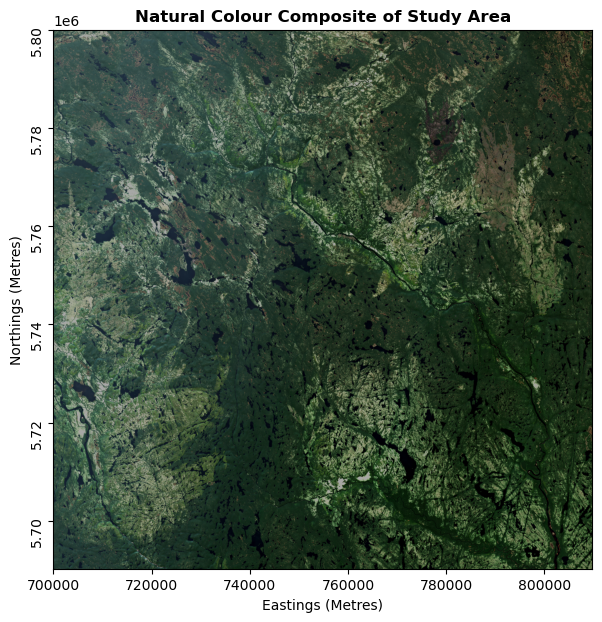

In [4]:
# Let's view the natural colour composite

# Open natural composite raster
natural_comp_raster = rio.open(out_raster_nat)

# Read natural composite raster as an array
natural_comp_array = natural_comp_raster.read()

# Print the shape (bands, rows, cols) to make sure it looks good
print(natural_comp_array.shape)

# Transpose the array
natural_comp_array = natural_comp_array.transpose(1,2,0)
print(natural_comp_array.shape)

# Clip the lower and upper 2 percentiles to elminate a potential contrast decrease caused by outliers
p2, p98 = np.percentile(natural_comp_array, (2,98)) 

# Use skimage to rescale the intensity. The values will range from 0 to 1
natural_comp_array = exposure.rescale_intensity(natural_comp_array, in_range=(p2, p98)) / 100000

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the natural colour composite
title = "Natural Colour Composite of Study Area"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(natural_comp_array.transpose(2,0,1), transform=natural_comp_raster.transform, title=title, ax=ax)

# Save fig
out_fig = "../Figures/naturalColour.png"
plt.savefig(out_fig, bbox_inches='tight')

In [5]:
# Let's make a false colour composite

# Set out raster path
out_raster_false = "../Raster/studyArea_falseColour.tif"

# Write the shortwave infrared, infrared, and blue bands to the out raster
# **meta adds the metadata we saved
with rio.open(out_raster_false, 'w', **meta) as dest:
    dest.write(b12.read(1),1)
    dest.write(b8a.read(1),2)
    dest.write(b2.read(1),3)

(3, 5490, 5490)
(5490, 5490, 3)


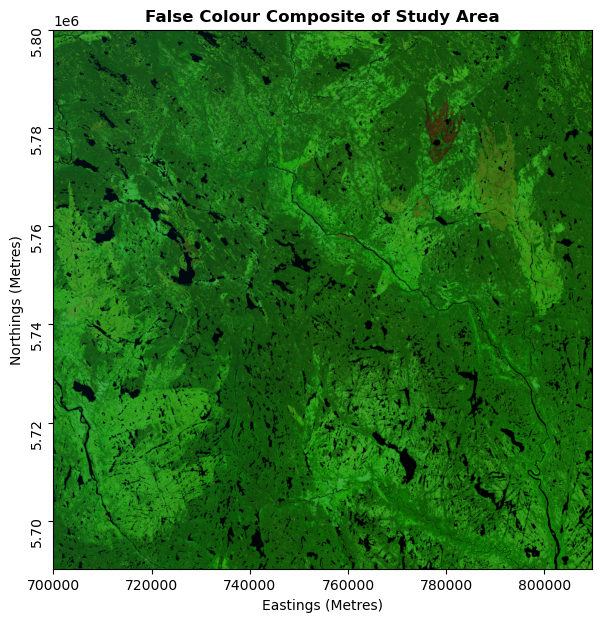

In [6]:
# Let's view the false colour composite

# Open false composite raster
false_comp_raster = rio.open(out_raster_false)

# Read false composite raster as an array
false_comp_array = false_comp_raster.read()

# Print the shape (bands, rows, cols) to make sure it looks good
print(false_comp_array.shape)

# Transpose the array
false_comp_array = false_comp_array.transpose(1,2,0)
print(false_comp_array.shape)

# Clip the lower and upper 2 percentiles to elminate a potential contrast decrease caused by outliers
p2, p98 = np.percentile(false_comp_array, (2,98)) 

# Use skimage to rescale the intensity. The values will range from 0 to 1
false_comp_array = exposure.rescale_intensity(false_comp_array, in_range=(p2, p98)) / 100000

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the false colour composite
title = "False Colour Composite of Study Area"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(false_comp_array.transpose(2,0,1), transform=false_comp_raster.transform, title=title, ax=ax)

# Save fig
out_fig = "../Figures/falseColour.png"
plt.savefig(out_fig, bbox_inches='tight')

In [7]:
# Create a Normalized Burn Ratio (NBR)
# NBR = (NIR - SWIR) / (NIR + SWIR)

# Read in NIR & SWIR bands
nir = b8a.read()
swir = b12.read()

# Calculate NBR
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

# Extract metadata from one of the bands and update
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

# Set out raster path
out_raster_nbr = "../Raster/studyArea_NBR.tif"

# Write the NBR to the out raster
with rio.open(out_raster_nbr, 'w', **meta) as dest:
    dest.write(nbr.astype(rio.float32))

(1, 5490, 5490)


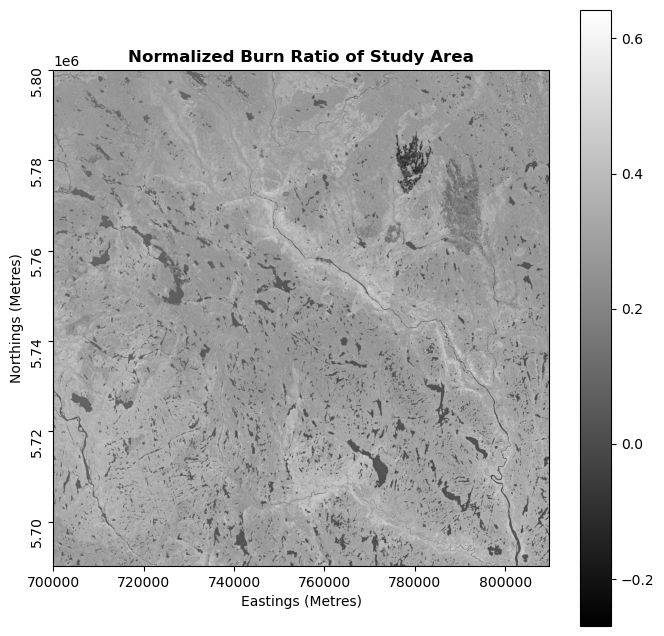

In [8]:
# Let's view the Normalized Burn Ratio raster

nbr_raster = rio.open(out_raster_nbr)
nbr_array = nbr_raster.read()

# Print the shape (bands, rows, cols) to make sure it looks good
print(nbr_array.shape)

# Define a plot
fig, ax = plt.subplots(figsize=(8,8), dpi=200)

# Display NBR
title = "Normalized Burn Ratio of Study Area"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(nbr_array, transform=nbr_raster.transform, cmap='gist_gray', title=title, ax=ax)
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(nbr_array), vmax=np.nanmax(nbr_array)), cmap='gist_gray'), ax=ax)

# Save fig
out_fig = "../Figures/normalizedBurnRatio.png"
plt.savefig(out_fig, bbox_inches='tight')

In [9]:
# Let's create a water mask
# The scl raster is a classified raster. Pixels with a value of 6 are water

# Read in the scl raster
scl_array = scl.read()

# Create a water mask by making all values != 6 equal to 0
# Converting to 0 will help when adding the water mask to the unsupervised classification
water_mask = np.where(scl_array != 6, 0, scl_array)

water_path = '../Raster/studyArea_waterMask.tif'

with rio.open(water_path, 'w', **meta) as dest:
    dest.write(water_mask.astype(rio.float32))

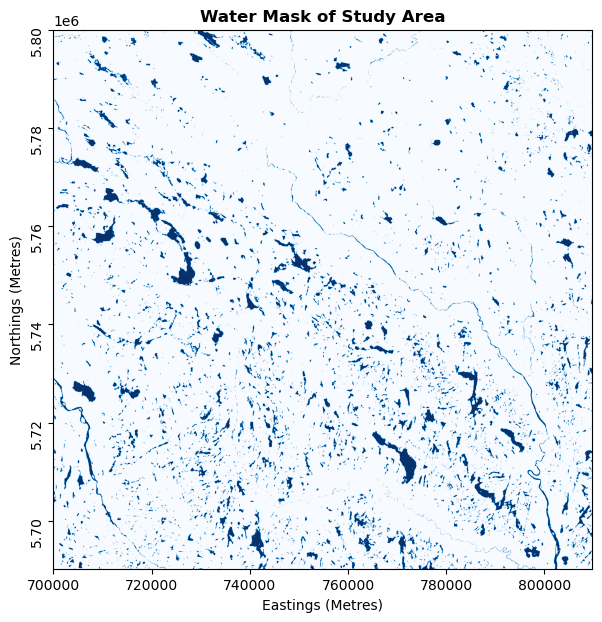

In [10]:
# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the water mask
title = "Water Mask of Study Area"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(water_mask, transform=nbr_raster.transform, cmap='Blues', title=title, ax=ax)

# Save fig
out_fig = "../Figures/waterMask.png"
plt.savefig(out_fig, bbox_inches='tight')

## Unsupervised Classification

(5490, 5490, 1)
CPU times: total: 1min 7s
Wall time: 31.8 s


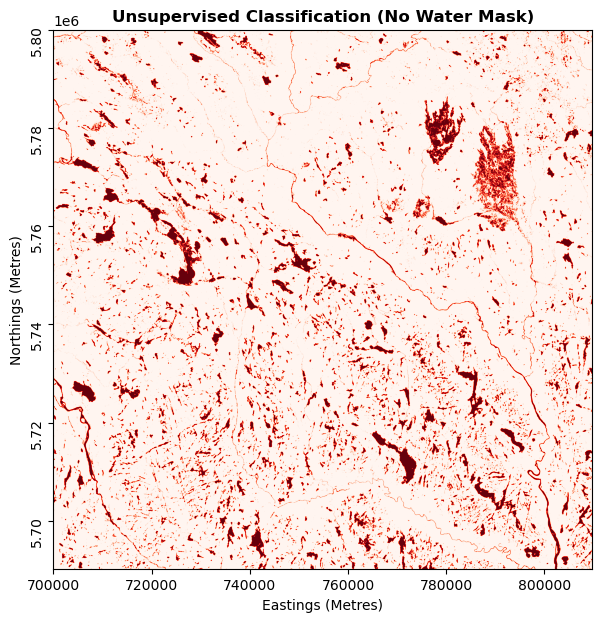

In [11]:
%%time

# Perform an unsupervised classification

# Create an empty array with the same dimensions and data type as our raster array
empty_array = np.empty((nbr_raster.height, nbr_raster.width, nbr_raster.count), nbr_raster.meta['dtype'])
print(empty_array.shape)

# Loop through the NBR's bands to fill the empty array
for band in range(empty_array.shape[2]):
    empty_array[:,:,band] = nbr_raster.read(band+1)

# Convert to 1d array
nbr_1d = empty_array[:,:,:3].reshape((empty_array.shape[0]*empty_array.shape[1],empty_array.shape[2]))

# Perform K Means cluster on NBR 
cl = cluster.KMeans(n_clusters=2)
param = cl.fit(nbr_1d)

# Get the labels of the classes and reshape back to original rows & cols (5490, 5490)
img_cl = cl.labels_
img_cl = img_cl.reshape(empty_array[:,:,0].shape)

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display unsupervised classification without water mask applied
title = "Unsupervised Classification (No Water Mask)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(img_cl, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/unsupervised_noMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [12]:
# Remove water from classified raster

water_raster = rio.open(water_path)
water_array = water_raster.read()

no_water = img_cl.astype(rio.float32) + water_array.astype(rio.float32)

classified_no_water = np.where(no_water > 1, 0, no_water)

meta = water_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

unsupervised_path = '../Raster/unsupervisedClassification_uncleaned.tif'

with rio.open(unsupervised_path, 'w', **meta) as dest:
    dest.write(classified_no_water.astype(rio.float32))

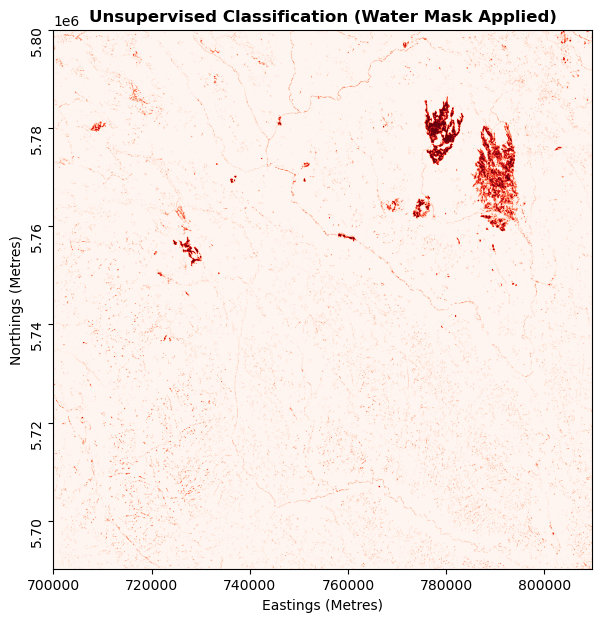

In [13]:
# Let's view the unsupervised classification with the water mask applied

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the unsupervised classification with the water mask applied
title = "Unsupervised Classification (Water Mask Applied)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(classified_no_water, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/unsupervised_waterMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [14]:
# Clean the unsupervised classification by removing noise

# Read in the classified raster and convert to boolean
unsupervised_raster = rio.open(unsupervised_path)
unsupervised_array = unsupervised_raster.read().astype(bool)

# Use skimage to remove pixel clusters that are smaller in size
unsup_cleaned = morphology.remove_small_objects(unsupervised_array, min_size=300, connectivity=1)

# Get count of True pixels (pixels that are burned)
burn_pixels = np.count_nonzero(unsup_cleaned == True)

# Get total burnt area in hectares
# Number of pixels times 20x20 m pixel size divided by 10000
total_area_hect = burn_pixels * 400 / 10000
# How many American football fields is that?
football = (total_area_hect * 2.471) / 1.32

print(f"Based on our unsupervised classification, as of Sept 22, 2023, an estimated {total_area_hect:,.2f} hectares of land has been damaged by wildfires within our study area.")
print(f"That's the equivilant of {football:,.2f} American football fields!")

meta = unsupervised_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

unsup_burnScar_path = '../Raster/burnScars_unsupervisedClassification.tif'

with rio.open(unsup_burnScar_path, 'w', **meta) as dest:
    dest.write(unsup_cleaned.astype(rio.float32))

Based on our unsupervised classification, as of Sept 22, 2023, an estimated 10,239.80 hectares of land has been damaged by wildfires within our study area.
That's the equivilant of 19,168.60 American football fields!


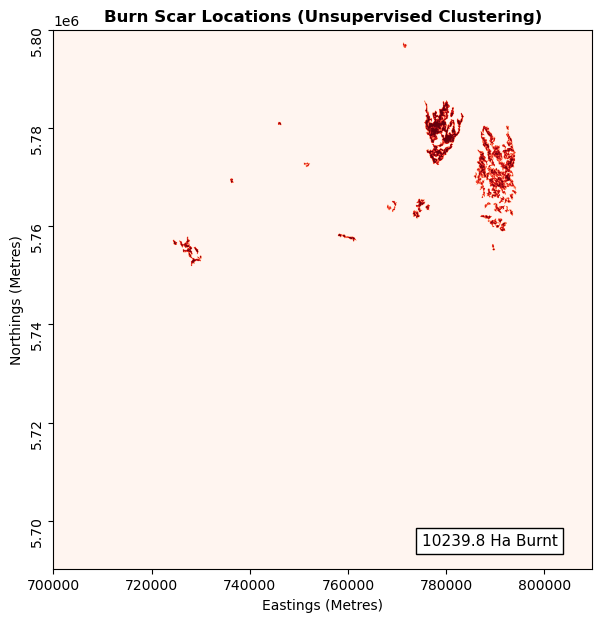

In [15]:
# Let's view the cleaned unsupervised classification

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

title = "Burn Scar Locations (Unsupervised Clustering)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
unsup_hect = str(total_area_hect) + " Ha Burnt"
ax.text(775000, 5695000, unsup_hect, fontsize=11, bbox={'facecolor': 'white'})
show(unsup_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/unsupervised_burnScars.png"
plt.savefig(out_fig, bbox_inches='tight')

## Train the data

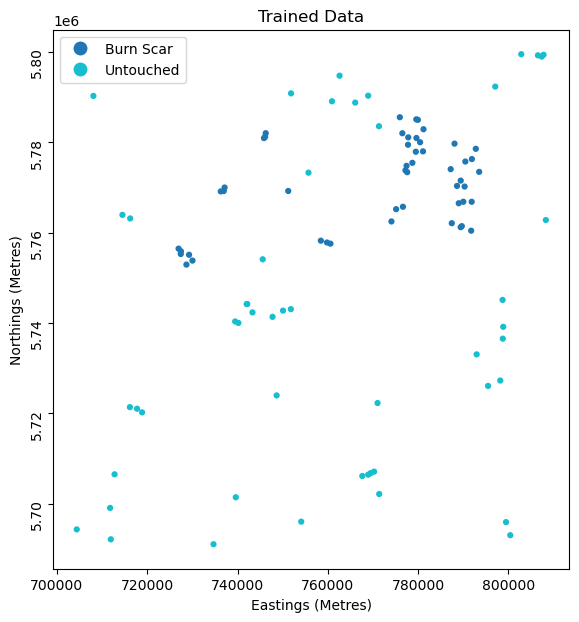

In [16]:
# Bring in training data shapefile using Geopandas
training_path = "../Vector/trainingData_pts.shp"
training_data = gpd.read_file(training_path)

# Create class list
classes = ['Untouched', 'Burn Scar']

# Display training data
training_data.plot(column='Classname', cmap=None, legend=True, markersize=12, figsize=(7, 7))

plt.title("Trained Data")
plt.xlabel("Eastings (Metres)")
plt.ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')

# Save fig
out_fig = "../Figures/trainingData.png"
plt.savefig(out_fig, dpi=200, bbox_inches='tight')

In [17]:
# Add ID column to training data
training_data = training_data.assign(id=range(len(training_data)))
print(training_data.head())

# Save a copy of the training data with the ID column
train_ID_path = "../Vector/trainingData_withID.shp"
training_data.to_file(train_ID_path)

   Classcode  Classname  Classvalue  RED  GREEN  BLUE  Count  \
0        NaN  Burn Scar           1  171     24     9      1   
1        NaN  Burn Scar           1  171     24     9      1   
2        NaN  Burn Scar           1  171     24     9      1   
3        NaN  Burn Scar           1  171     24     9      1   
4        NaN  Burn Scar           1  171     24     9      1   

                                 geometry  id  
0  POINT Z (777745.456 5779491.695 0.000)   0  
1  POINT Z (781179.267 5782927.134 0.000)   1  
2  POINT Z (781071.336 5778028.561 0.000)   2  
3  POINT Z (778719.162 5775492.869 0.000)   3  
4  POINT Z (777427.597 5774827.366 0.000)   4  


In [18]:
# Let's train our data

# Read training data as DataFrame
training_df = pd.DataFrame(training_data.drop(columns=['geometry', 'Classcode']))
# Create an empty series
sampled = pd.Series()

# Read input shapefile with fiona and iterate over each feature
with fiona.open(train_ID_path) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value of NBR raster at the given coordinates and add to series
        value = [v for v in nbr_raster.sample([coords])]
        sampled.loc[siteID] = value

# Reshape sampled values and add to new DataFrame
df = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df['id'] = df.index
df = pd.DataFrame(df[0].values.tolist(), columns=['PixelValue'])
df['id'] = df.index

# Merge sampled DataFrame and training Dataframe
data = pd.merge(df, training_df, on ='id')

# Set X & y
X = data.iloc[:,0:1].values
y = data.iloc[:,3].values

# Train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

## Supervised Classification using Support Vector Machines (C-Support Vector Classification)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


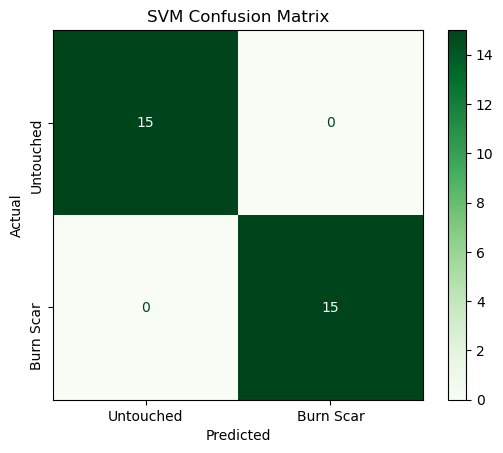

In [19]:
# Let's fit our training data & create a confusion matrix for our SVM

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_svm = clf.predict(X_test)

# Get labels from SVM for confusion matrix
labels = clf.classes_

# Calculate accuracy
accuracy = accuracy_score(y_test,clf_svm)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_test, clf_svm, average = 'macro')
print(f"Precision: {precision}")

# Calculate recall 
recall = recall_score(y_test, clf_svm, average = 'macro')
print(f"Recall: {recall}")

# Create confusion Matrix
conf_matrix = confusion_matrix(y_test, clf_svm, labels=labels)

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels = classes)
cmd.plot(cmap='Greens')

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation='vertical')

# Save fig
out_fig = "../Figures/svm_confMatrix.png"
plt.savefig(out_fig, dpi=200, bbox_inches='tight')

CPU times: total: 10.1 s
Wall time: 16.1 s


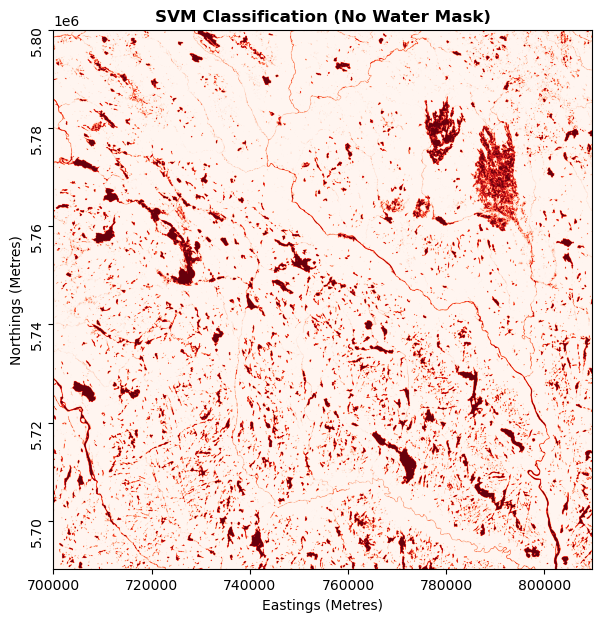

In [20]:
%%time

# Let's perform a SVM classification on our data

svm_pred = clf.predict(nbr_1d).reshape(empty_array[:,:,0].shape)

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the SVM Classification
title = "SVM Classification (No Water Mask)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(svm_pred, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/svm_noMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [21]:
# Remove water from classified raster

svm_no_water = svm_pred.astype(rio.float32) + water_array.astype(rio.float32)

svm_no_water = np.where(svm_no_water > 1, 0, svm_no_water)

meta = water_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

svm_path = '../Raster/svmClassification_uncleaned.tif'

with rio.open(svm_path, 'w', **meta) as dest:
    dest.write(svm_no_water.astype(rio.float32))

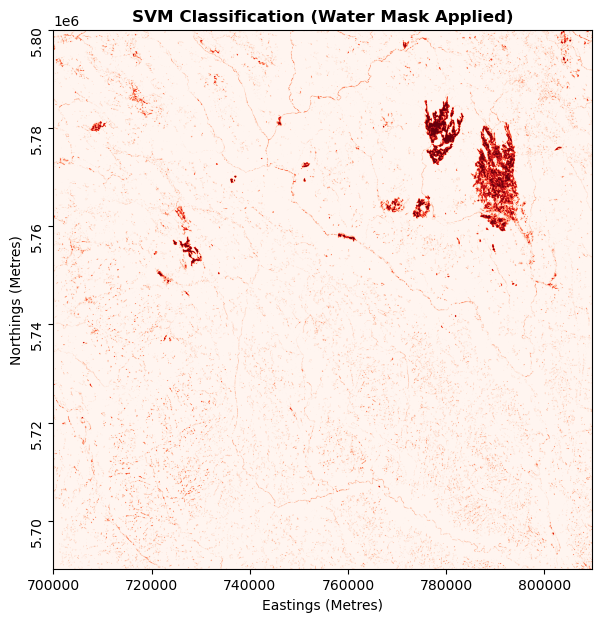

In [22]:
# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the SVM Classification with the water mask applied
title = "SVM Classification (Water Mask Applied)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(svm_no_water, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/svm_waterMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [23]:
# Clean the svm classification by removing noise

# Read in the classified raster and convert to boolean
svm_raster = rio.open(svm_path)
svm_array = svm_raster.read().astype(bool)

# Use skimage to remove pixel clusters that are smaller in size
svm_cleaned = morphology.remove_small_objects(svm_array, 
                                              min_size=300, connectivity=1)

# Get count of True pixels (pixels that are burned)
burn_pixels = np.count_nonzero(svm_cleaned == True)

# Get total burnt area in hectares
# Number of pixels times 20x20 m pixel size divided by 10000
total_area_hect = burn_pixels * 400 / 10000
# How many American football fields is that?
football = (total_area_hect * 2.471) / 1.32

print(f"Based on our SVM classification, as of Sept 22, 2023, an estimated "
      f"{total_area_hect:,.2f} hectares of land has been damaged by "
      f"wildfires within our study area.")
print(f"That's the equivalent of {football:,.2f} American football fields!")

meta = svm_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

svm_burnScar_path = '../Raster/burnScars_svmClassification.tif'

with rio.open(svm_burnScar_path, 'w', **meta) as dest:
    dest.write(svm_cleaned.astype(rio.float32))

Based on our SVM classification, as of Sept 22, 2023, an estimated 13,858.88 hectares of land has been damaged by wildfires within our study area.
That's the equivalent of 25,943.40 American football fields!


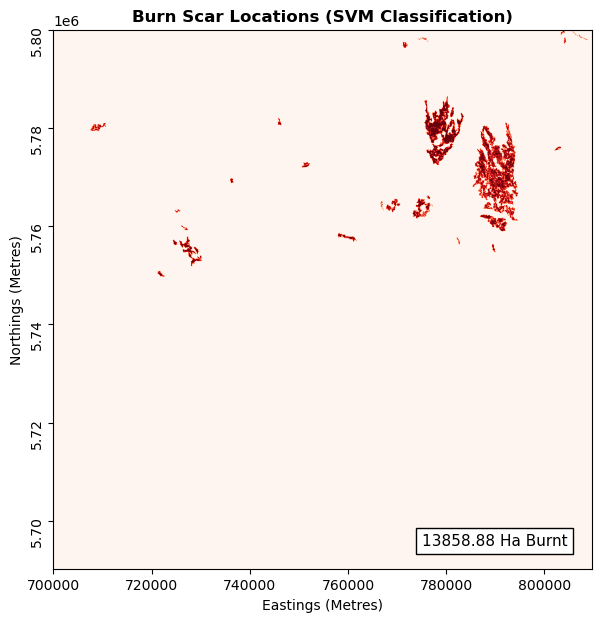

In [24]:
# Let's view the cleaned SVM classification

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the cleaned SVM Classification
title = "Burn Scar Locations (SVM Classification)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
svm_hect = str(total_area_hect) + " Ha Burnt"
ax.text(775000, 5695000, svm_hect, fontsize=11, bbox={'facecolor': 'white'})
show(svm_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/svm_burnScars.png"
plt.savefig(out_fig, bbox_inches='tight')

## Supervised Classification using Random Forest

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


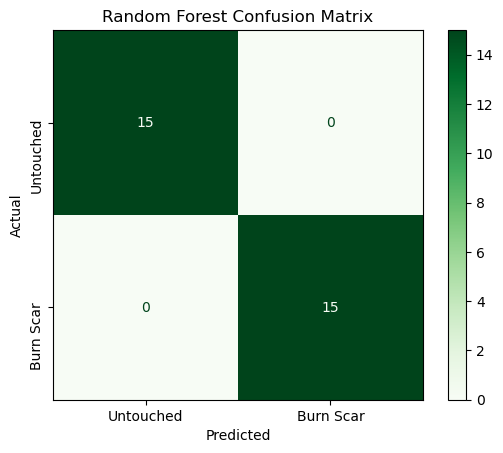

In [25]:
# Let's fit our training data & create a confusion matrix for our RF

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_rf = clf.predict(X_test)

# Get labels from RF for confusion matrix
labels = clf.classes_

# Calculate accuracy
accuracy = accuracy_score(y_test,clf_rf)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_test, clf_rf, average = 'macro')
print(f"Precision: {precision}")

# Calculate recall 
recall = recall_score(y_test, clf_rf, average = 'macro')
print(f"Recall: {recall}")

# Create confusion Matrix
conf_matrix = confusion_matrix(y_test, clf_rf, labels=labels)

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels = classes)
cmd.plot(cmap='Greens')

plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation='vertical')

# Save fig
out_fig = "../Figures/rf_confMatrix.png"
plt.savefig(out_fig, dpi=200, bbox_inches='tight')

CPU times: total: 39.3 s
Wall time: 1min 5s


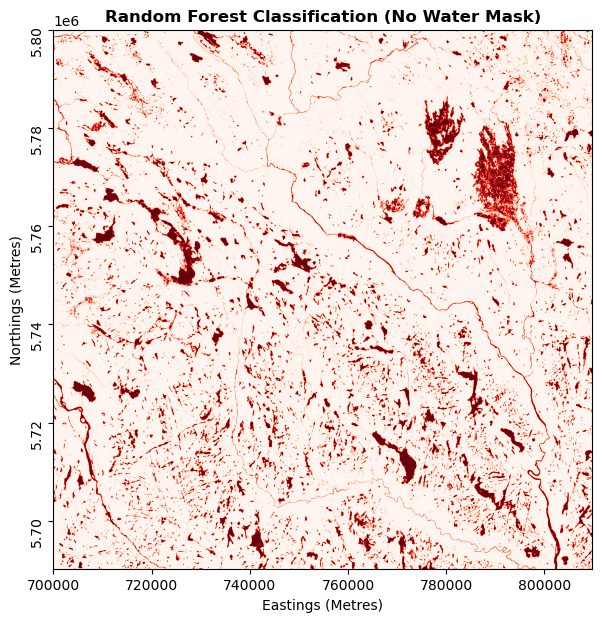

In [26]:
%%time

# Predict using Random Forest
rf_pred = clf.predict(nbr_1d).reshape(empty_array[:,:,0].shape)

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the Random Forest Classification with no water mask applied
title = "Random Forest Classification (No Water Mask)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(rf_pred, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/rf_noMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [27]:
# Remove water from classified raster

rf_no_water = rf_pred.astype(rio.float32) + water_array.astype(rio.float32)

rf_no_water = np.where(rf_no_water > 1, 0, rf_no_water)

meta = water_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

rf_path = '../Raster/rfClassification_uncleaned.tif'

with rio.open(rf_path, 'w', **meta) as dest:
    dest.write(rf_no_water.astype(rio.float32))

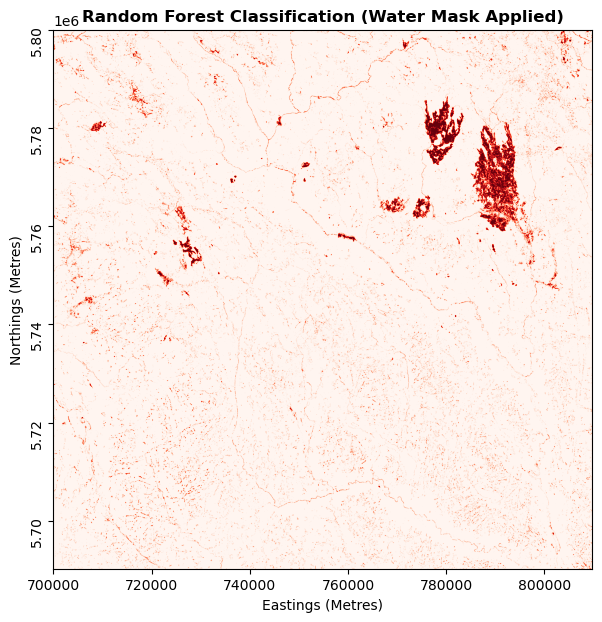

In [28]:
# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the Random Forest Classification with the water mask applied
title = "Random Forest Classification (Water Mask Applied)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(rf_no_water, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/rf_waterMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [29]:
# Clean the rf classification by removing noise

# Read in the classified raster and convert to boolean
rf_raster = rio.open(rf_path)
rf_array = rf_raster.read().astype(bool)

# Use skimage to remove pixel clusters that are smaller in size
rf_cleaned = morphology.remove_small_objects(rf_array, min_size=300, connectivity=1)

# Get count of True pixels (pixels that are burned)
burn_pixels = np.count_nonzero(rf_cleaned == True)

# Get total burnt area in hectares
# Number of pixels times 20x20 m pixel size divided by 10000
total_area_hect = burn_pixels * 400 / 10000
# How many American football fields is that?
football = (total_area_hect * 2.471) / 1.32

print(f"Based on our Random Forest classification, as of Sept 22, 2023, an estimated {total_area_hect:,.2f} hectares of land has been damaged by wildfires within our study area.")
print(f"That's the equivalent of {football:,.2f} American football fields!")

meta = rf_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

rf_burnScar_path = '../Raster/burnScars_rfClassification.tif'

with rio.open(rf_burnScar_path, 'w', **meta) as dest:
    dest.write(rf_cleaned.astype(rio.float32))

Based on our Random Forest classification, as of Sept 22, 2023, an estimated 16,299.56 hectares of land has been damaged by wildfires within our study area.
That's the equivalent of 30,512.28 American football fields!


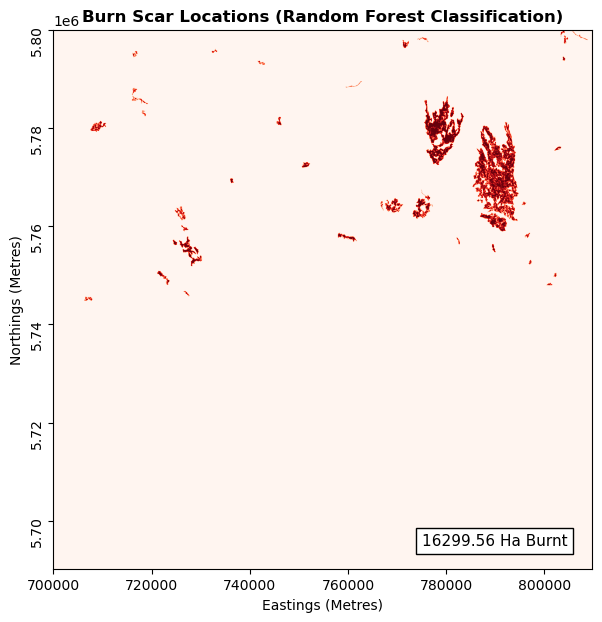

In [30]:
# Let's view the cleaned Random Forest classification

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the cleaned Random Forest Classification
title = "Burn Scar Locations (Random Forest Classification)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
rf_hect = str(total_area_hect) + " Ha Burnt"
ax.text(775000, 5695000, rf_hect, fontsize=11, bbox={'facecolor': 'white'})
show(rf_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/rf_burnScars.png"
plt.savefig(out_fig, bbox_inches='tight')

## Supervised Classification using Decision Trees

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


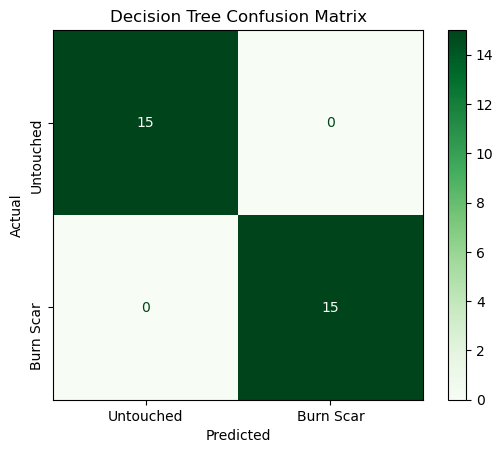

In [31]:
# Let's fit our training data & create a confusion matrix for our DT

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_dt = clf.predict(X_test)

# Get labels from DT for confusion matrix
labels = clf.classes_

# Calculate accuracy
accuracy = accuracy_score(y_test,clf_dt)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_test, clf_dt, average = 'macro')
print(f"Precision: {precision}")

# Calculate recall 
recall = recall_score(y_test, clf_dt, average = 'macro')
print(f"Recall: {recall}")

# Create confusion Matrix
conf_matrix = confusion_matrix(y_test, clf_dt, labels=labels)

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels = classes)
cmd.plot(cmap='Greens')

plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation='vertical')

# Save fig
out_fig = "../Figures/dt_confMatrix.png"
plt.savefig(out_fig, dpi=200, bbox_inches='tight')

CPU times: total: 734 ms
Wall time: 1.77 s


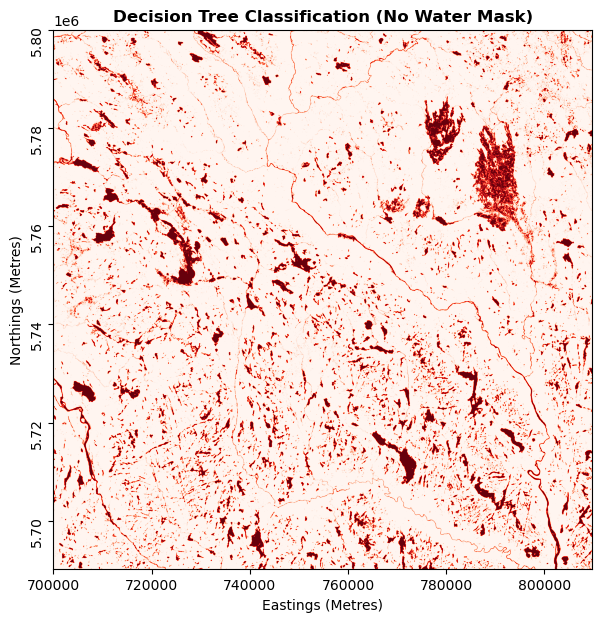

In [32]:
%%time

# Predict using Decision Trees
dt_pred = clf.predict(nbr_1d).reshape(empty_array[:,:,0].shape)

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the Decision Tree Classification with no water mask applied
title = "Decision Tree Classification (No Water Mask)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(dt_pred, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/dt_noMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [33]:
# Remove water from classified raster

dt_no_water =dt_pred.astype(rio.float32) + water_array.astype(rio.float32)

dt_no_water = np.where(dt_no_water > 1, 0, dt_no_water)

meta = water_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

dt_path = '../Raster/dtClassification_uncleaned.tif'

with rio.open(dt_path, 'w', **meta) as dest:
    dest.write(dt_no_water.astype(rio.float32))

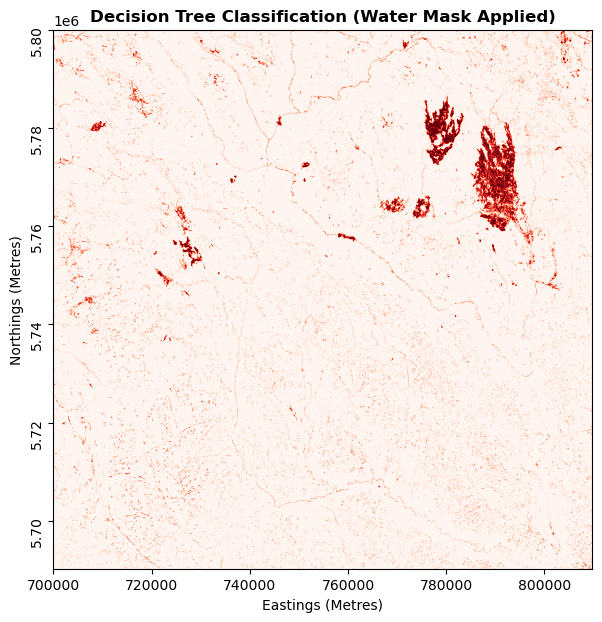

In [34]:
# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the Decision Tree Classification with the water mask applied
title = "Decision Tree Classification (Water Mask Applied)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
show(dt_no_water, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/dt_waterMask.png"
plt.savefig(out_fig, bbox_inches='tight')

In [35]:
# Clean the dt classification by removing noise

# Read in the classified raster and convert to boolean
dt_raster = rio.open(dt_path)
dt_array = dt_raster.read().astype(bool)

# Use skimage to remove pixel clusters that are smaller in size
dt_cleaned = morphology.remove_small_objects(dt_array, min_size=300, connectivity=1)

# Get count of True pixels (pixels that are burned)
burn_pixels = np.count_nonzero(dt_cleaned == True)

# Get total burnt area in hectares
# Number of pixels times 20x20 m pixel size divided by 10000
total_area_hect = burn_pixels * 400 / 10000
# How many American football fields is that?
football = (total_area_hect * 2.471) / 1.32

print(f"Based on our Decision Tree classification, as of Sept 22, 2023, an estimated {total_area_hect:,.2f} hectares of land has been damaged by wildfires within our study area.")
print(f"That's the equivalent of {football:,.2f} American football fields!")

meta = dt_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

dt_burnScar_path = '../Raster/burnScars_dtClassification.tif'

with rio.open(dt_burnScar_path, 'w', **meta) as dest:
    dest.write(dt_cleaned.astype(rio.float32))

Based on our Decision Tree classification, as of Sept 22, 2023, an estimated 16,299.56 hectares of land has been damaged by wildfires within our study area.
That's the equivalent of 30,512.28 American football fields!


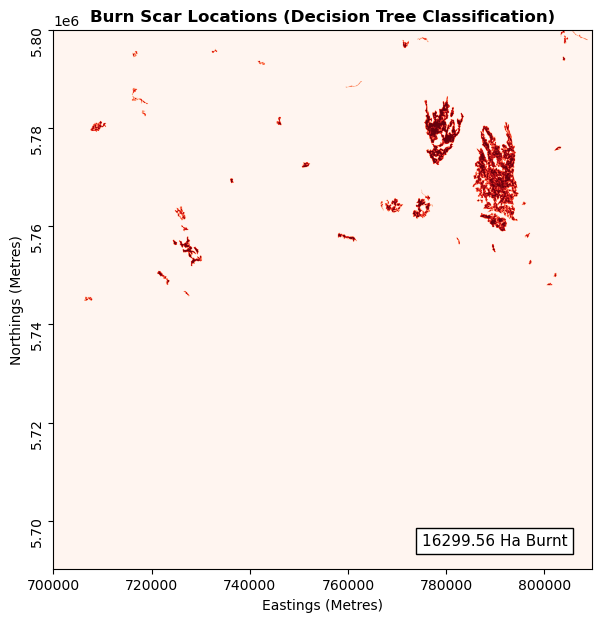

In [36]:
# Let's view the cleaned decision tree classification

# Define a plot
fig, ax = plt.subplots(figsize=(7,7), dpi=200)

# Display the cleaned Decision Tree Classification
title = "Burn Scar Locations (Decision Tree Classification)"
ax.set_xlabel("Eastings (Metres)")
ax.set_ylabel("Northings (Metres)")
plt.yticks(rotation='vertical')
dt_hect = str(total_area_hect) + " Ha Burnt"
ax.text(775000, 5695000, dt_hect, fontsize=11, bbox={'facecolor': 'white'})
show(dt_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title, ax=ax)

# Save fig
out_fig = "../Figures/dt_burnScars.png"
plt.savefig(out_fig, bbox_inches='tight')

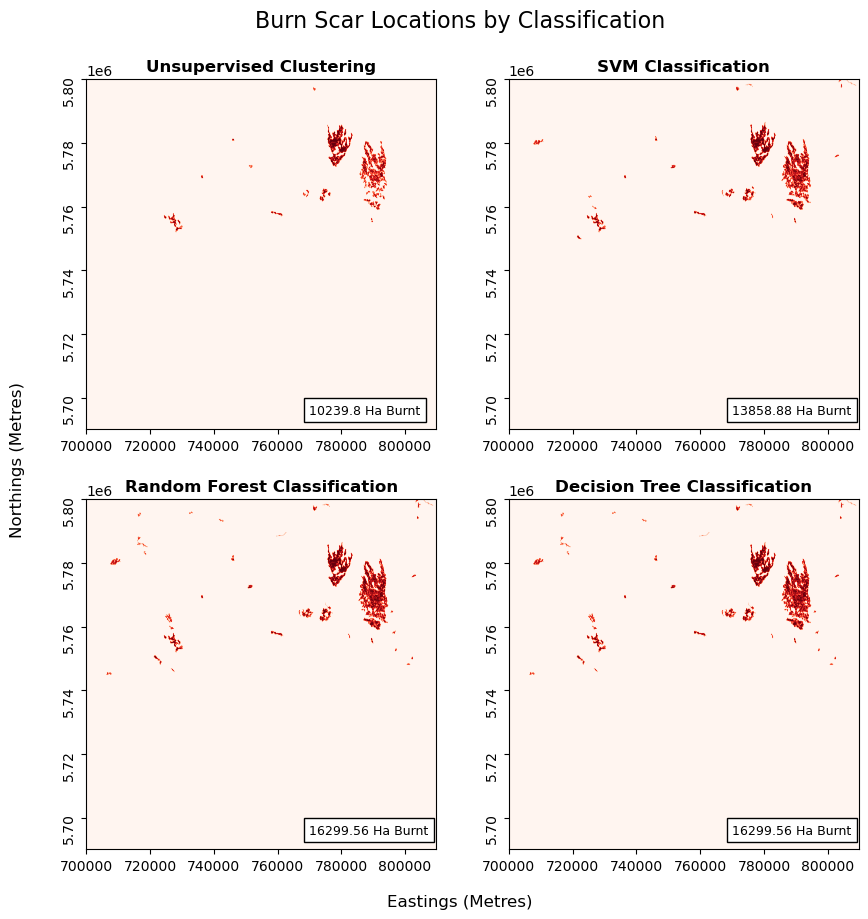

In [37]:
# Let's add all our classifications to one figure
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=200)

fig.suptitle('Burn Scar Locations by Classification', y=0.95, fontsize=16)
fig.supxlabel("Eastings (Metres)", y=0.05)
fig.supylabel("Northings (Metres)", x=0.05)

title1 = "Unsupervised Clustering"
title2 = "SVM Classification"
title3 = "Random Forest Classification"
title4 = "Decision Tree Classification"

ax1.tick_params(axis='y', labelrotation=90)
ax2.tick_params(axis='y', labelrotation=90)
ax3.tick_params(axis='y', labelrotation=90)
ax4.tick_params(axis='y', labelrotation=90)

ax1.text(770000, 5695000, unsup_hect, fontsize=9, bbox={'facecolor': 'white'})
ax2.text(770000, 5695000, svm_hect, fontsize=9, bbox={'facecolor': 'white'})
ax3.text(770000, 5695000, rf_hect, fontsize=9, bbox={'facecolor': 'white'})
ax4.text(770000, 5695000, dt_hect, fontsize=9, bbox={'facecolor': 'white'})

# Display classifications
show(unsup_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title1, ax=ax1)
show(svm_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title2, ax=ax2)
show(rf_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title3, ax=ax3)
show(dt_cleaned, transform=nbr_raster.transform, cmap='Reds', title=title4, ax=ax4)

# Save fig
out_fig = "../Figures/burnScars_allClassifications.png"
plt.savefig(out_fig, bbox_inches='tight')